In [240]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [241]:
from fastai.text import *

In [242]:
data_path = Config.data_path()/'amazon-fine-foods'; data_path.mkdir(parents=True, exist_ok=True)

In [243]:
data_path.ls()

[PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods.txt'),
 PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods_processed_sample.csv'),
 PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods_processed.csv'),
 PosixPath('/home/jupyter/.fastai/data/amazon-fine-foods/finefoods.csv')]

In [244]:
df = pd.read_csv(data_path/'finefoods.csv')

In [245]:
nans = df[df.isnull().any(axis=1)]; nans.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
25509,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0/0,5.0,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
33958,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1/24,2.0,1173312000,NaN,I only used two maybe three tea bags and got p...
38874,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2/3,1.0,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
40548,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1/24,2.0,1173312000,NaN,I only used two maybe three tea bags and got p...
49800,B000CRHQN0,A2LYFY32LXQDON,NaN,0/0,2.0,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...


In [246]:
print(df.shape)
print(nans.shape)

(568454, 8)
(43, 8)


In [247]:
df = df.drop(list(nans.index.values));

In [248]:
df.shape

(568411, 8)

Create two new columns:
 - one **concatenating the summary and text** since the two are both useful for sentiment analysis (this will be the independent variable for training)
 - the **sentiment of the review** (the dependent variable/label) which can be 'positive'/'negative'

In [253]:
separator = ' '
df["review/summary_and_text"] = df["review/summary"].map(str) + separator + df["review/text"]
df['label'] = df.apply(lambda row: 'positive' if row['review/score'] > 2.0 else 'negative', axis=1) 

In [254]:
df.sort_values(by=['review/userId'], inplace=True);
df.reset_index(drop=True, inplace=True)

In [255]:
df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review/summary_and_text,label
0,B006Q820X0,#oc-R103C0QSV1DF5E,C,1/2,5.0,1343088000,Great for the Price,I have to say I was a little apprehensive to b...,Great for the Price I have to say I was a litt...,positive
1,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0/1,5.0,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...,AWESOME Coffee!!!! Received my free K cups as ...,positive
2,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0/1,5.0,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...,Brooklyn Bean Roastery Breakfast Blend K-Cups ...,positive
3,B0026LJ3EA,#oc-R10LT57ZGIB140,dipr,0/0,3.0,1310601600,Some damage,The shipment of the dog food was quick. Howev...,Some damage The shipment of the dog food was q...,positive
4,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0/0,1.0,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on...",Less than satisfactory. I gave the Brooklyn K...,negative


Binarize the sentiment classes.

## EDA

- unique products
- unique users
- reviews per user
- review scores
- review lengths
- summary lengths
- reviews by year

# Language Model

## Data

In [290]:
bs = 50

In [ ]:
data_lm = (TextList.from_df(df, cols='review/summary_and_text')
          .split_by_rand_pct(0.1, seed=42)
          .label_for_lm()
          .databunch(bs=bs))

In [280]:
data_lm.save('data_lm.pkl')

In [283]:
data_lm = load_data('.', 'data_lm.pkl', bs=bs)

In [284]:
data_lm.show_batch(3)

idx,text
0,"it . xxmaj overall , i was impressed . xxbos xxup awesome xxmaj coffee xxrep 4 ! xxmaj received my free k cups as a sample promotion and xxup love them . i have at least one a day at work xxrep 4 ! xxbos xxmaj some damage xxmaj the shipment of the dog food was quick . xxmaj however , when i opened the main box which contained several"
1,"xxmaj the best snack ! ! ! i always have these in our pantry ! xxmaj they are great when you want just something to nibble on , and also amazing in salads ! ! xxmaj the sea salt and garlic are without a doubt my favorite flavor of theirs . xxmaj do n't be hesitant about the garlic in them . xxmaj it 's really not strong at all"
2,have tried . xxmaj it is bold with a really nice finish . xxmaj not at all bitter like some of the decafs i have tried . xxbos xxmaj best xxmaj bold decaf xxmaj this is the best xxmaj decaf k - cup i have tried . xxmaj it is bold with a really nice finish . xxmaj not at all bitter like some of the decafs i have tried


## Model

In [287]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [288]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


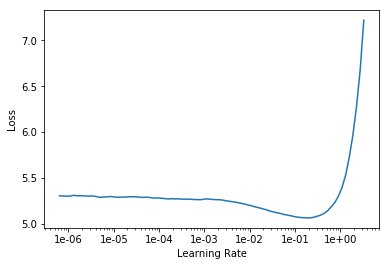

In [289]:
learn.recorder.plot()

In [292]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.724845,3.569823,0.315026,44:11


In [294]:
learn.save'lm-full-fit-head')

In [299]:
learn.load('lm-full-fit-head');

In [300]:
learn.fit_one_cycle(4, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.790637,3.724273,0.304310,50:16
1,3.794094,3.720109,0.305392,50:09
2,3.474240,3.403054,0.340417,50:05
3,3.310427,3.265811,0.357368,50:13


In [301]:
learn.save('lm-full-fit-head-2')

In [302]:
learn.unfreeze()

In [303]:
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.280616,3.239791,0.361205,50:09
1,3.257486,3.209735,0.365563,50:06
2,3.256770,3.178166,0.370407,50:08
3,3.229292,3.167437,0.372244,50:14


In [304]:
learn.save('lm-full-fine-tuned')

In [134]:
learn.fit_one_cycle(20, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.728981,2.299493,0.518214,00:02
1,1.742770,2.288274,0.526571,00:02
2,1.746530,2.285398,0.526929,00:02
3,1.782730,2.323930,0.522071,00:02
4,1.823334,2.374992,0.513500,00:02
5,1.851986,2.344787,0.524286,00:02
6,1.841829,2.333323,0.527786,00:02
7,1.801954,2.283542,0.540000,00:02
8,1.743771,2.280068,0.545000,00:02
9,1.690039,2.250839,0.556571,00:02


In [135]:
learn.fit_one_cycle(20, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.229430,2.103215,0.601214,00:02
1,1.243691,2.115628,0.603429,00:02
2,1.275947,2.139658,0.600500,00:02
3,1.327195,2.176066,0.592071,00:02
4,1.401523,2.235896,0.578071,00:02
5,1.469458,2.266831,0.568071,00:02
6,1.520986,2.258892,0.570500,00:02
7,1.520537,2.247596,0.581214,00:02
8,1.504328,2.220938,0.587000,00:02
9,1.468936,2.195905,0.591071,00:02


In [136]:
learn.save('lm-sample-stage1')

In [138]:
learn.load('lm-sample-stage1');

In [139]:
learn.unfreeze()

In [141]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


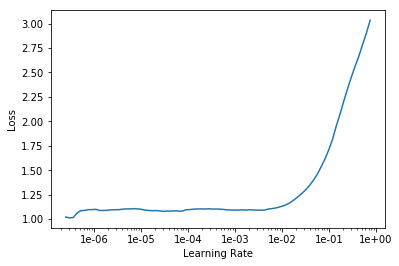

In [143]:
learn.recorder.plot(skip_start=5)

In [144]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.096167,2.059725,0.639500,00:03
1,1.057453,1.951390,0.664643,00:03
2,0.931338,1.927690,0.682643,00:03
3,0.765764,1.918792,0.701571,00:03
4,0.638192,1.920125,0.702286,00:03


In [145]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.533428,1.918742,0.703071,00:03
1,0.522401,1.939321,0.708286,00:03
2,0.511157,1.950399,0.707214,00:03
3,0.469382,1.929419,0.721143,00:03
4,0.400731,1.930153,0.724929,00:03
5,0.347054,1.931658,0.729714,00:03
6,0.291338,1.909365,0.731714,00:03
7,0.248097,1.916204,0.733286,00:03
8,0.217809,1.911038,0.734000,00:03
9,0.202054,1.912425,0.734571,00:03


In [148]:
learn.save('lm-sample-stage2');

In [149]:
learn.load('lm-sample-stage2');

In [150]:
TEXT = "I liked this "
N_WORDS = 40
N_SENTENCES = 2

In [151]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this  coffee ! It had a strong bitter flavor . i would not buy it again . xxbos Weak i found this coffee very weak - i had to lower the cup size to get some flavor . i
I liked this  coffees flavor , but i have n't had the same consistent taste with a cup of Starbucks . The flavor is a bit weak as well . Not too strong , but not bitter . The


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [152]:
learn.save_encoder('sample-encoder')

## Classifier

In [260]:
n_reviews = df.shape[0]

We should make sure that the splits contain reviews from different users (e.g., there isn't a review from the same user both in the train and validation set). This makes our test and validation results more trustworthy.

In [276]:
last_train_idx = int(n_reviews * 0.6)

In [277]:
last_valid_idx = last_train_idx + int(n_reviews * 0.2) + 1

In [ ]:
data_clas = (TextList.from_df(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [154]:
bs = 50

In [163]:
data_clas = (TextList.from_df(df, cols='review/summary_and_text', vocab=data_lm.vocab)
       .split_by_idxs(train_idx=np.arange(600), valid_idx=np.arange(600, 800))
       .label_from_df(cols='label')
       .databunch(bs=bs))

In [164]:
data_clas.show_batch()

text,target
"xxbos xxup not xxup funny xxrep 4 ! / xxup update : xxup second xxup gift xxup basket i xxup received i must admit , i have n't gotten many gift baskets in my time . xxmaj if this one is any xxunk of what a gift basket is like , xxmaj xxunk not missing anything xxrep 4 ! \n \n xxmaj to start with , the gift basket",negative
"xxbos xxmaj improved their product ... xxmaj amazon & xxmaj brookly xxmaj bean xxmaj roastery fair to customers : ) xxmaj below was my original review , but here is my updated review as of xxmaj june 2012 . xxmaj first off i 'd like to say that i thought the company xxunk very quickly on their not so good reviews . i commend them for xxunk out to their",positive
"xxbos xxmaj worth another try ! xxmaj update to previous reviews . xxmaj tried this coffee based pretty much on the xxunk xxunk price . i was a little skeptical about trying this product based on the reviews , due to the explosion issues . xxmaj reviewers did n't rave on the taste too much however . xxmaj so after receiving these cups , i gave one a xxunk ,",positive
xxbos xxmaj spectacular xxmaj brewing xxmaj failures but much less frequent ( caffeinated only ) xxmaj something about the xxmaj brooklyn xxmaj bridge compelled me to try this product and - admittedly - i xxunk all over the k xxmaj cup xxunk trying each variety . i should also note that i 'm xxunk a coffee expert ; even gas station coffee that has been sitting for two hours tastes,positive
"xxbos xxmaj chasing the xxmaj fog and xxmaj xxunk the xxmaj bug ! i have been drinking coffee for over 40 plus years now . xxmaj folks , i have tried so many varieties from xxmaj instant to xxmaj drip to k cups , and the list goes on . xxmaj hopefully , the xxunk gets the picture ... i love my coffee . xxmaj yet , i am not",negative


In [165]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('sample-encoder')

In [166]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


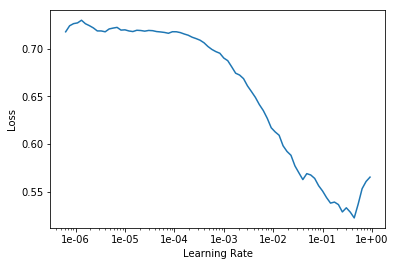

In [167]:
learn.recorder.plot()

In [169]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.606030,0.630352,0.810000,00:03
1,0.498407,0.597689,0.630000,00:03
2,0.460408,0.459320,0.805000,00:03
3,0.422422,0.560153,0.705000,00:03
4,0.392094,0.459595,0.805000,00:03
5,0.353980,0.528725,0.760000,00:03
6,0.322431,0.590283,0.755000,00:03
7,0.298153,0.425798,0.830000,00:03
8,0.273339,0.454576,0.820000,00:03
9,0.256947,0.460293,0.820000,00:03


In [170]:
learn.save('sample-classifier-1')

In [172]:
learn.load('sample-classifier-1');

In [178]:
learn.freeze_to(-2)

In [187]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


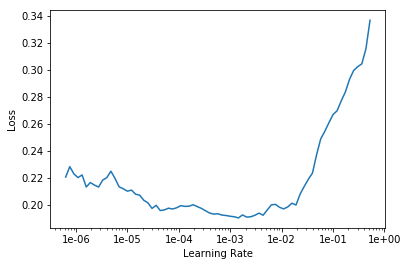

In [188]:
learn.recorder.plot()

In [189]:
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.197248,0.493959,0.825000,00:03
1,0.242128,0.610975,0.765000,00:03
2,0.257164,0.405434,0.785000,00:03
3,0.228656,0.416360,0.820000,00:03
4,0.193240,0.409208,0.825000,00:03


In [190]:
learn.save('sample-classifier-2')

In [207]:
learn.load('sample-classifier-2');

In [208]:
learn.freeze_to(-3)

In [199]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


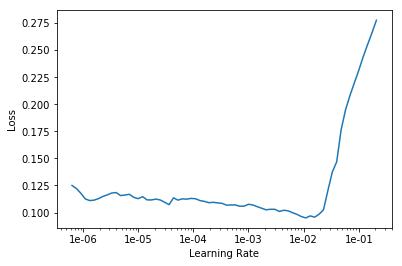

In [200]:
learn.recorder.plot()

In [209]:
learn.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.139773,0.416657,0.820000,00:04
1,0.112322,0.406276,0.820000,00:04
2,0.103150,0.410612,0.820000,00:04


In [213]:
learn.save('sample-classifier-3')

In [214]:
learn.load('sample-classifier-3');

In [215]:
learn.unfreeze()

In [216]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


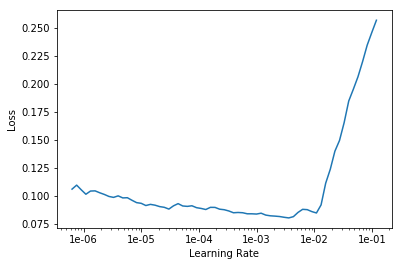

In [217]:
learn.recorder.plot()

In [218]:
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.094368,0.423077,0.820000,00:05
1,0.084386,0.433370,0.815000,00:05
2,0.078067,0.444124,0.820000,00:05
3,0.073801,0.451509,0.820000,00:05


In [228]:
a = learn.predict("What a bad disappointing shame thing.")

In [231]:
str(a[0])

'positive'

## Test evaluation

In [234]:
preds, true = [], []
for i in np.arange(800, 1000):
    text = df.iloc[i]['review/summary_and_text']
    true_label = df.iloc[i]['label']
    pred_label = str(learn.predict(text)[0])
    preds.append(pred_label)
    true.append(true_label)

In [239]:
(np.array(preds) == np.array(true)).mean()

0.705